## Libraries and data Loading

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz

from multivariateGCI_mr import MultivariateGCI_mr
from multivariateGCI_sr import MultivariateGCI_sr

from qiskit import QuantumRegister, QuantumCircuit, Aer, execute, IBMQ, transpile, ClassicalRegister
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem, AmplitudeEstimation
from qiskit.providers.aer.noise import NoiseModel
from qiskit.circuit.library import LinearAmplitudeFunction, PhaseEstimation, QFT, GroverOperator

In [ ]:
df = pd.read_csv("Data/sampled_counterparts.csv")
# df = df[((df['pd']>=0.1) & ((1000 < df['lgd dwt']*df['ead']) & (df['lgd dwt']*df['ead'] < 5000000)))]
df =  df.iloc[[38-2, 260-2]] #df.iloc[[38-2, 260-2, 7816-2]] 

F_matrix = pd.read_csv("Data/F_for_sampled_counterparts.csv")
sectors = [1] #[1, 2]
F_values = [[F_matrix.iloc[df.index.values[j]][i-1] for i in sectors] for j in range(len(df))]
# F_values = [[0.55], [0.65], [0.50]] # make F/rhos

## Parameters setting

In [ ]:
# set problem parameters
n_z = 2
z_max = 2

p_zeros = [el['pd'] for _, el in df.iterrows()]
rhos = [el['is']**2 for _, el in df.iterrows()]
lgd = [el['lgd dwt']*el['ead'] for _, el in df.iterrows()]

K = len(p_zeros)

alpha_var = 0.05

print(f'F: {F_values}\nRhos: {np.sqrt(rhos)}\nLgds: {lgd}\np_zeros: {p_zeros}')
df

### Encoding of the uncertainty model

In [ ]:
u = MultivariateGCI_sr(n_z, z_max, p_zeros, rhos, F_values[1])
u = MultivariateGCI_mr(n_z, z_max, p_zeros, rhos, F_values)

# from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel as GCI

# u = GCI(n_z, z_max, p_zeros, rhos)

# print(u.decompose().draw(output='latex_source'))
u.decompose().draw("mpl", filename='Images/u_circuit.svg')

## Uncertainty model testing

In [ ]:
# run the circuit and analyze the results
job = execute(u, backend=Aer.get_backend('statevector_simulator'),) # n_shots=n_shots)

# analyze uncertainty circuit and determine exact solutions
p_z = np.zeros(2**n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = u.num_qubits
for i, a in enumerate(np.array(job.result().get_statevector())):
    
    # get binary representation
    b = ('{0:0%sb}' % num_qubits).format(i)
    prob = np.abs(a)**2
    
    # extract value of Z and corresponding probability    
    i_normal = int(b[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k 
    loss = 0
    for k in range(K):
        if b[K - k - 1] == '1':
            p_default[k] += prob
            loss += lgd[k]
    values += [loss]
    probabilities += [prob]   

values = np.array(values)
probabilities = np.array(probabilities)
    
expected_loss = np.dot(values, probabilities)

losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1-alpha_var)
exact_var = losses[i_var]

print('Expected Loss E[L]:                %.4f' % expected_loss)
print('Value at Risk VaR[L]:              %.4f' % exact_var)

# plot loss CDF
plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (8, 8)
plt.plot(np.sort(np.unique(losses)), cdf, 'o-g')
plt.axhline(1-alpha_var, color="orange", linestyle="--")
   
plt.xlabel("Loss L (\$)", size=17)
plt.ylabel(r'$P[\mathcal{L} \leq X]$', size=17) 
plt.title ("CDF of Total Loss", size=17)
plt.xticks(size=17) # plt.xticks(np.sort(np.unique(losses)), np.sort(np.unique(losses)), size=17)
plt.yticks(size=17)
plt.savefig('Images/cdf.svg', dpi=400, bbox_inches = "tight")
plt.show()
cdf

In [ ]:
def mapping(decimal_number):
    b = ('{0:0%sb}' % K).format(decimal_number)
    #print(b)
    losses = [loss for i, loss in enumerate(lgd[::-1]) if b[i]=='1']
    #print(losses)
    total_loss = sum(losses)
    return total_loss

def find_breakpoint(x_eval):
    for el in range(0,2**K):
        if mapping(el) <= x_eval:
            if mapping(el+1) >= x_eval:
                return el
    return 0

depth = 'e_loss'

In [ ]:
if depth == 'e_loss':
    # define linear objective function for expected loss
    breakpoints = list(range(0,2**K))
    slopes = [0]*len(breakpoints)
    offsets = [mapping(el) for el in breakpoints]
    f_min = 0
    f_max = sum(lgd)
    c_approx = 0.01

    objective_e_loss = LinearAmplitudeFunction(
        K,
        slope=slopes, 
        offset=offsets, 
        # max value that can be reached by the qubit register (will not always be reached)
        domain=(0, 2**K-1),  
        image=(f_min, f_max),
        rescaling_factor=c_approx,
        breakpoints=breakpoints
    )

In [ ]:
# from qiskit.circuit.library import WeightedAdder

# agg = WeightedAdder(n_z + K, [0] * n_z + lgd)

# # define linear objective function
# breakpoints = [0]
# slopes = [1]
# offsets = [0]
# f_min = 0
# f_max = sum(lgd)
# c_approx = 0.25

# objective_loss = LinearAmplitudeFunction(
#     agg.num_sum_qubits,
#     slope=slopes,
#     offset=offsets,
#     # max value that can be reached by the qubit register (will not always be reached)
#     domain=(0, 2 ** agg.num_sum_qubits - 1),
#     image=(f_min, f_max),
#     rescaling_factor=c_approx,
#     breakpoints=breakpoints,
# )

## Testing without QAE

In [ ]:
from qiskit.circuit.library import LinearAmplitudeFunction


def get_cdf_circuit(x_eval):
    
    # define linear objective function for cdf
    breakpoints = list(range(0,2**K))
    slopes = [0]*len(breakpoints)
    # print(values)
    offsets = [1 if mapping(el)<=x_eval else 0 for el in breakpoints]
    f_min = 0
    f_max = 1
    c_approx = 0.01
    
    objective = LinearAmplitudeFunction(
        K,
        slope=slopes, 
        offset=offsets, 
        # max value that can be reached by the qubit register (will not always be reached)
        domain=(0, 2**K-1),  
        image=(f_min, f_max),
        rescaling_factor=c_approx,
        breakpoints=breakpoints
    )

    # define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, 'state')
    qr_obj = QuantumRegister(1, 'objective')
    ar = QuantumRegister(objective.num_ancillas, "work")  # additional qubits

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, ar, name='A')

    # load the random variable
    state_preparation.append(u.to_gate(), qr_state)

    # linear objective function (does aggregation and comparison)
    if depth == 'e_loss':
        state_preparation.append(objective_e_loss.to_gate(), qr_state[-K:] + qr_obj[:] + ar[:])
        return state_preparation, objective_e_loss
    else:
        state_preparation.append(objective.to_gate(), qr_state[-K:] + qr_obj[:] + ar[:])
        return state_preparation, objective
    
example = 0
state_preparation, objective = get_cdf_circuit(example)
job = execute(state_preparation, backend=Aer.get_backend('statevector_simulator'))

# evaluate resulting statevector
var_prob = 0
for i, a in enumerate(np.array(job.result().get_statevector())):
    b = ('{0:0%sb}' % (u.num_qubits + 1)).format(i)[-(u.num_qubits + 1):]
    prob = np.abs(a)**2
    if b[0] == '1':
        var_prob += prob
if depth == 'e_loss':
    print('Operator Expected Loss' + ' = %.4f' % objective.post_processing(var_prob), var_prob)
else:
    print('Operator CDF(%s)' % example + ' = %.4f' % objective.post_processing(var_prob))
state_preparation.draw()
# objective.decompose().decompose().draw()

## Experiments
### Setup

In [ ]:
import time
# set target precision and confidence level
epsilon = 0.01/6
alpha = 0.05/6

simulated = True
optimization_level = 1
n_shots = 2048

# get backend
backend_name = 'ibm_perth'
try:
    provider = IBMQ.get_provider(hub='ibm-q-research-2', group='politecnico-tor-1', project='main')
except:
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q-research-2', group='politecnico-tor-1', project='main')
    
backend = provider.get_backend(backend_name)

qi_ideal = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=n_shots, 
                           optimization_level=optimization_level, seed_transpiler=42)

if simulated == False:
    qi_noise = QuantumInstance(backend, shots=n_shots, 
                            optimization_level=optimization_level, seed_transpiler=42)
                            
else:
    noise_model = NoiseModel.from_backend(backend)
    # Get coupling map from backend
    coupling_map = backend.configuration().coupling_map
    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates

    qi_noise = QuantumInstance(provider.get_backend('ibmq_qasm_simulator'), shots=n_shots, 
                           optimization_level=optimization_level, seed_transpiler=42,
                           noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)

### Running and saving

result with no noise: 7796.697825432917 0.4938187776817583 dept: 3


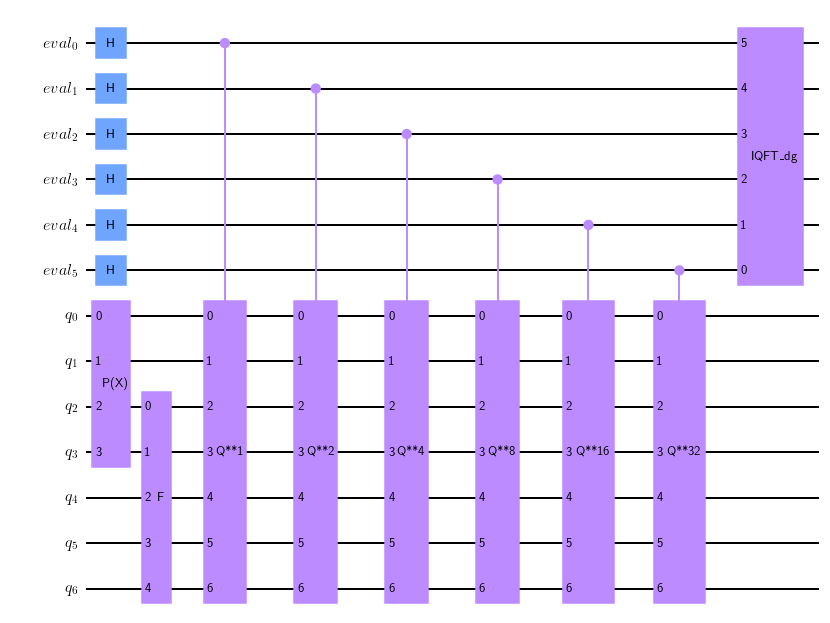

In [59]:
qi_ideal = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=10000, 
                           optimization_level=optimization_level, seed_transpiler=42)
problem = EstimationProblem(state_preparation=state_preparation,
                            objective_qubits=[u.num_qubits],
                            post_processing=objective.post_processing)

ae_parallel = AmplitudeEstimation(6, quantum_instance=qi_ideal)
circuit = ae_parallel.construct_circuit(problem)

ideal_result = ae_parallel.estimate(problem)
print("result with no noise:", ideal_result.mle_processed, ideal_result.mle, "dept:")
circuit.decompose().draw("mpl")

In [112]:
from qiskit.test.mock import FakeMontreal
if depth == 'e_loss':
    #from qiskit.visualization import plot_circuit_layout

    tr_ae_circuit = transpile(circuit, optimization_level=optimization_level, backend=FakeMontreal(), seed_transpiler=42)
    
    # Return circuit depth (i.e., length of critical path).
    print(tr_ae_circuit.depth())
    # Returns total number of instructions in circuit.
    print(tr_ae_circuit.size()) 

    #plot_circuit_layout(tr_ae_circuit, backend)

883039
1186068


In [107]:
grover_op2 = problem.grover_operator #GroverOperator(oracle2, state_preparation)
grover_op2.decompose().draw()

global phase: π
                                 ┌──────────┐┌───┐     ┌───┐┌───────┐      
state_0: ────────────────────────┤0         ├┤ X ├──■──┤ X ├┤0      ├──────
                                 │          │├───┤  │  ├───┤│       │      
state_1: ────────────────────────┤1         ├┤ X ├──■──┤ X ├┤1      ├──────
                        ┌───────┐│  P(X)_dg │├───┤  │  ├───┤│  P(X) │┌────┐
state_2: ───────────────┤0      ├┤2         ├┤ X ├──■──┤ X ├┤2      ├┤0   ├
                        │       ││          │├───┤  │  ├───┤│       ││    │
state_3: ───────────────┤1      ├┤3         ├┤ X ├──■──┤ X ├┤3      ├┤1   ├
         ┌───┐┌───┐┌───┐│       │└──┬───┬───┘└───┘  │  ├───┤└───────┘│    │
state_4: ┤ H ├┤ X ├┤ H ├┤2 F_dg ├───┤ X ├───────────■──┤ X ├─────────┤2 F ├
         └───┘└───┘└───┘│       │   ├───┤           │  ├───┤         │    │
state_5: ───────────────┤3      ├───┤ X ├───────────■──┤ X ├─────────┤3   ├
                        │       │   ├───┤    ┌───┐┌─┴─┐├───┤  ┌───┐  │    │
state_6: ───────────────┤4      ├───┤ X ├────┤ H ├┤ X ├┤ H ├──┤ X ├──┤4   ├
                        └───────┘   └───┘    └───┘└───┘└───┘  └───┘  └────┘

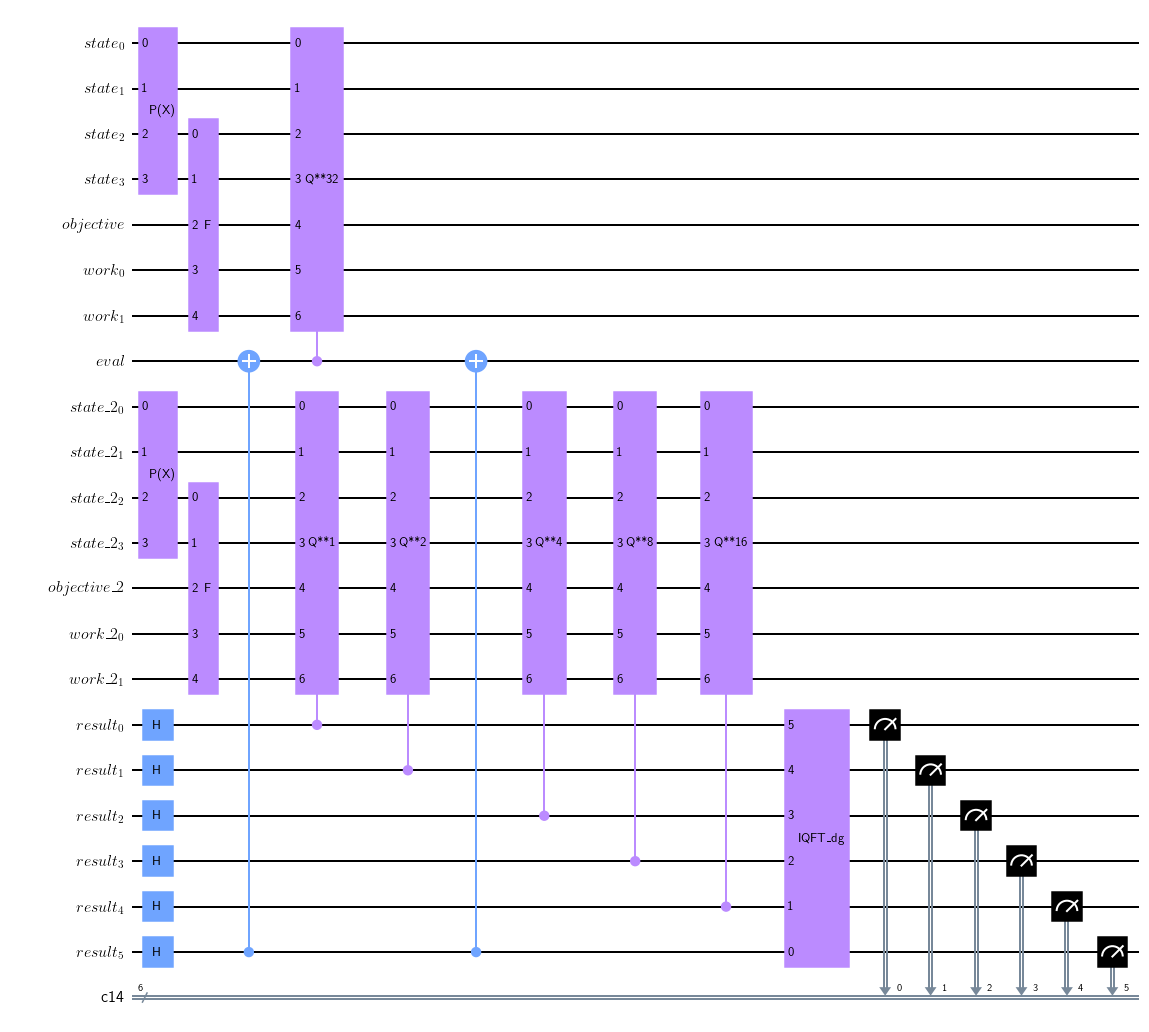

In [99]:
resolution = 6
iqft = QFT(resolution, inverse=True, do_swaps=False).reverse_bits()
def get_parallelized_circuit():
    
    # define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, 'state')
    qr_obj = QuantumRegister(1, 'objective')
    ar = QuantumRegister(objective.num_ancillas, "work")  # additional qubits

    qr_state2 = QuantumRegister(u.num_qubits, 'state_2')
    qr_obj2 = QuantumRegister(1, 'objective_2')
    ar2 = QuantumRegister(objective.num_ancillas, "work_2")  # additional qubits

    qr_result = QuantumRegister(resolution, 'result')
    qr_eval = QuantumRegister(1, 'eval')

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, ar, qr_eval, qr_state2, qr_obj2, ar2, qr_result, name='A')

    for i in range(resolution):
        state_preparation.h(qr_result[i]) # hadamards on evaluation qubits
    # state_preparation.h(qr_result[1])

    # load the random variable
    state_preparation.append(u.to_gate(), qr_state)
    state_preparation.append(u.to_gate(), qr_state2)

    # state_preparation.cx(qr_result[0], qr_eval[0])



    # linear objective function (does aggregation and comparison)
    state_preparation.append(objective_e_loss.to_gate(), qr_state[-K:] + qr_obj[:] + ar[:])
    state_preparation.append(objective_e_loss.to_gate(), qr_state2[-K:] + qr_obj2[:] + ar2[:])
    state_preparation.cx(qr_result[resolution-1], qr_eval[0])
    # state_preparation.append(problem.grover_operator.to_gate(), qr_state[:] + qr_obj[:] + ar[:])
    
    state_preparation.compose(grover_op2.power(2**(resolution-1)).control(), qubits=qr_eval[:]+qr_state[:] + qr_obj[:] + ar[:], inplace=True)
    
    state_preparation.compose(grover_op2.power(2**0).control(), qubits=qr_result[:1]+qr_state2[:] + qr_obj2[:] + ar2[:], inplace=True)

    state_preparation.compose(grover_op2.power(2**1).control(), qubits=qr_result[1:2]+qr_state2[:] + qr_obj2[:] + ar2[:], inplace=True)

    state_preparation.compose(grover_op2.power(2**2).control(), qubits=qr_result[2:3]+qr_state2[:] + qr_obj2[:] + ar2[:], inplace=True)

    state_preparation.compose(grover_op2.power(2**3).control(), qubits=qr_result[3:4]+qr_state2[:] + qr_obj2[:] + ar2[:], inplace=True)

    state_preparation.compose(grover_op2.power(2**4).control(), qubits=qr_result[4:5]+qr_state2[:] + qr_obj2[:] + ar2[:], inplace=True)

    state_preparation.cx(qr_result[resolution-1], qr_eval[0])
    state_preparation.compose(iqft, qubits=qr_result[:], inplace=True)
    
    # state_preparation.append(qpe.to_gate(), qr_eval[:] + qr_state2[:] + qr_obj2[:] + ar2[:])
    # state_preparation.cx(qr_result[0], qr_result[0])
    cr = ClassicalRegister(resolution)
    state_preparation.add_register(cr)
    state_preparation.measure(qr_result[:], list(range(resolution)))

    return state_preparation, objective_e_loss

    
state_preparation2, objective = get_parallelized_circuit()
state_preparation2.draw("mpl")


In [108]:
from collections import OrderedDict
from qiskit.algorithms.amplitude_estimators.ae_utils import pdf_a, bisect_max

def evaluate_count_results(counts):
    # construct probabilities
    measurements = OrderedDict()
    samples = OrderedDict()
    shots = 10000

    for state, count in counts.items():
        y = int(state.replace(" ", "")[:resolution][::-1], 2)
        probability = count / shots
        measurements[y] = probability
        a = np.round(np.power(np.sin(y * np.pi / 2**resolution), 2), decimals=7)
        samples[a] = samples.get(a, 0.0) + probability

    return samples, measurements


counts = qi_ideal.execute(state_preparation2).get_counts()#job.result().get_counts()

samples, measurements = evaluate_count_results(counts)
samples_processed = {
            problem.post_processing(a): p for a, p in samples.items()
        }
# determine the most likely estimate
max_probability = 0
for amplitude, (mapped, prob) in zip(samples.keys(), samples_processed.items()):
    if prob > max_probability:
        max_probability = prob
        estimation = amplitude
        estimation_processed = mapped


def compute_mle(
        estimation, apply_post_processing: bool = False
    ) -> float:

        m = resolution
        M = 2**m  # pylint: disable=invalid-name
        qae = estimation

        # likelihood function
        a_i = np.asarray(list(samples.keys()))
        p_i = np.asarray(list(samples.values()))

        def loglikelihood(a):
            return np.sum(10000 * p_i * np.log(pdf_a(a_i, a, m)))

        # y is pretty much an integer, but to map 1.9999 to 2 we must first
        # use round and then int conversion
        y = int(np.round(M * np.arcsin(np.sqrt(qae)) / np.pi))

        # Compute the two intervals in which are candidates for containing
        # the maximum of the log-likelihood function: the two bubbles next to
        # the QAE estimate
        if y == 0:
            right_of_qae = np.sin(np.pi * (y + 1) / M) ** 2
            bubbles = [qae, right_of_qae]

        elif y == int(M / 2):  # remember, M = 2^m is a power of 2
            left_of_qae = np.sin(np.pi * (y - 1) / M) ** 2
            bubbles = [left_of_qae, qae]

        else:
            left_of_qae = np.sin(np.pi * (y - 1) / M) ** 2
            right_of_qae = np.sin(np.pi * (y + 1) / M) ** 2
            bubbles = [left_of_qae, qae, right_of_qae]

        # Find global maximum amongst the two local maxima
        a_opt = qae
        loglik_opt = loglikelihood(a_opt)
        for a, b in zip(bubbles[:-1], bubbles[1:]):
            locmax, val = bisect_max(loglikelihood, a, b, retval=True)
            if val > loglik_opt:
                a_opt = locmax
                loglik_opt = val

        if apply_post_processing:
            return problem.post_processing(a_opt)

        return a_opt

compute_mle(estimation, apply_post_processing=True)

9382.182523000372

In [111]:
if depth == 'e_loss':
    #from qiskit.visualization import plot_circuit_layout

    tr_ae_circuit = transpile(state_preparation2, optimization_level=optimization_level, backend=FakeMontreal(), seed_transpiler=42)
    
    # Return circuit depth (i.e., length of critical path).
    print(tr_ae_circuit.depth())
    # Returns total number of instructions in circuit.
    print(tr_ae_circuit.size()) 

    #plot_circuit_layout(tr_ae_circuit, backend)

455118
1183273
